# Part I

## Numpy Implementation

Nb of hidden layers = 3
Shape of layer # 0
(300, 785)
Shape of layer # 1
(300, 301)
Shape of layer # 2
(300, 301)
Shape of layer # 3
(10, 301)
__________________________________________________
Train on 60000 samples, validate on 5000 samples
Epoch : 1 / 20
60000/60000 [==============================] 100.0% - loss: 0.2295 - acc: 0.1124 - val_loss: 0.2294 - val_acc: 0.1122
Epoch : 2 / 20
60000/60000 [==============================] 100.0% - loss: 0.0760 - acc: 0.7548 - val_loss: 0.0748 - val_acc: 0.7564
Epoch : 3 / 20
60000/60000 [==============================] 100.0% - loss: 0.0429 - acc: 0.8724 - val_loss: 0.0429 - val_acc: 0.8706
Epoch : 4 / 20
60000/60000 [==============================] 100.0% - loss: 0.0368 - acc: 0.8906 - val_loss: 0.0369 - val_acc: 0.8842
Epoch : 5 / 20
60000/60000 [==============================] 100.0% - loss: 0.0305 - acc: 0.9111 - val_loss: 0.0308 - val_acc: 0.9050
Epoch : 6 / 20
60000/60000 [==============================] 100.0% - loss: 0.0282 - acc: 0.9

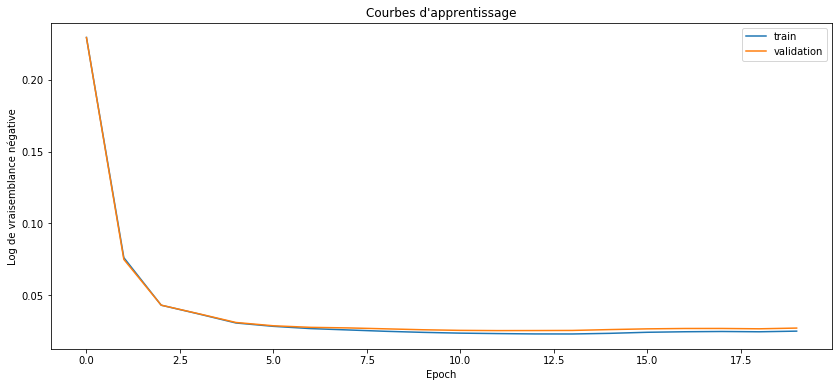

In [52]:
import time
import numpy as np
import sys
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


def one_hot(y, K):
    y_one_hot = np.zeros((y.shape[0], K))  # we have K classes, the general form is len(np.unique(y)
    y_one_hot[np.arange(y.shape[0]), y] = 1  # one hot target or shape NxK
    return y_one_hot


def softmax(x):
    # this condition is for debugging purposes,
    # so we could detect exploding gradients
    if (np.isnan(x).any()):
        print('There is nan in softmax')
    expZ = np.exp(x - np.amax(x, axis=1, keepdims=True))
    return np.divide(expZ, np.sum(expZ, axis=1, keepdims=True))


def softmax_backward(y, y_pred):
    return (y - y_pred)


def relu(x):
    # this test condition is for debugging purposes,
    # so we could detect exploding gradients
    if (np.isnan(x).any()):
        print('There is nan in relu')
    return np.maximum(x, 0)


def relu_backward(X):
    x = np.copy(X)
    x[x < 0] = 0.0
    x[x >= 0] = 1.0
    # we do not use the diagonal form of the matrix but we use the vector instead,
    # then we do an elementwise product later
    return x


def get_loss(y, y_pred):
    eps = 1.0e-10
    y_pred = np.clip(y_pred, eps, 1 - eps)  # to prevent dividing by zero
    # a = - np.mean(y * np.log(y_pred))
    return - np.nanmean(y * np.log(y_pred))


def get_accuracy(y_pred, y):

    return np.sum(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)) / len(y)


class NeuralNetwork:
    def __init__(self,
                 no_of_in_nodes,
                 no_of_out_nodes,
                 no_of_hidden_nodes,
                 no_of_hidden_layers):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.no_of_hidden_layers = no_of_hidden_layers
        self.Teta = self.create_weight_matrices()

    # generating matrix Teta of weights = [ W  b ]
    def create_weight_matrices(self):
        Teta = []
        print("Nb of hidden layers = " + str(self.no_of_hidden_layers))
        for i in range(0, self.no_of_hidden_layers + 1):
            if i == 0:
                input_nodes = self.no_of_in_nodes
                output_nodes = self.no_of_hidden_nodes
            elif i == self.no_of_hidden_layers:
                input_nodes = self.no_of_hidden_nodes
                output_nodes = self.no_of_out_nodes
            else:
                input_nodes = self.no_of_hidden_nodes
                output_nodes = self.no_of_hidden_nodes
            print("Shape of layer # " + str(i))
            Teta_layer = np.random.normal(0, 0.01,
                                          (output_nodes, input_nodes + 1))  # we add +1 to take b into consideration
            print(Teta_layer.shape)
            Teta.append(Teta_layer)
        return Teta  # list of np arrays

    # an optimised version of predict function
    def predict(self, X):
        # feedforward for all the examples and predict the output
        L = self.no_of_hidden_layers
        # forward pass for each example
        node_a_prev = np.copy(X)  # item j from the input vector of the example
        for l in range(1, L + 2):
            node_in = np.dot(node_a_prev, self.Teta[l - 1].T)  # in_i <- sum_j{W_j_i * a_j}
            if l < L + 1:
                # the hidden layers
                node_a_cur = relu(node_in)  # relu
                node_a_cur = np.concatenate((node_a_cur, np.ones((node_a_cur.shape[0], 1))), axis=1)  # add the bias b
            else:
                # the output layer
                node_a_cur = softmax(node_in)
            node_a_prev = np.copy(node_a_cur)
        return node_a_cur

    def progress(self, i, n):
        # just a fancy progress bar:
        sys.stdout.write('\r')
        sys.stdout.write("%5s/%5s [%-30s] %.1f%%" % (i, n, '=' * int(i * 30 / n), (100 / n) * i))
        sys.stdout.flush()

    def train(self, X_train, y_train, X_validation, y_validation, X_test, y_test, lr, nb_epochs, minibatch_size):
        # neural network with L hidden layers
        print('_' * 50)
        print('Train on %d samples, validate on %d samples' % (len(X_train), len(X_validation)))
        L = self.no_of_hidden_layers

        best_teta = None
        best_accuracy = 0
        losses_train = []
        losses_val = []

        for epoch in range(nb_epochs):
            loss = 0
            accuracy = 0
            print("Epoch : " + str(epoch + 1) + " / " + str(nb_epochs))

            for i in range(0, X_train.shape[0], minibatch_size):
                X_train_mini = X_train[i:i + minibatch_size] if (i + minibatch_size < X_train.shape[0]) \
                    else X_train[i:X_train.shape[0]]
                y_train_mini = y_train[i:i + minibatch_size] if (i + minibatch_size < X_train.shape[0]) \
                    else y_train[i:X_train.shape[0]]

                self.progress(i + minibatch_size, len(X_train))
                # forward pass for each example
                # for each layer node_in is the list of nodes where node_in = W x + b
                node_in = [None] * (L + 2)
                # for each layer node_a is the list of nodes
                # where node_a = f(node_in), f is the activation function
                node_a = [None] * (L + 2)
                # for each layer node_delta is the list of nodes
                # where node_delta = f'(node_in), f' is the derivative of activation function
                node_delta = [None] * (L + 2)
                node_a[0] = X_train_mini  # item j from the input vector of the example
                for l in range(1, L + 2):
                    TetaT = np.fastCopyAndTranspose(self.Teta[l - 1])
                    node_in[l] = node_a[l - 1] @ TetaT  # in_i <- sum_j{Teta_j_i * a_j}

                    if l < L + 1:
                        # the hidden layers
                        node_a[l] = relu(node_in[l])  # relu
                        node_a[l] = np.concatenate((node_a[l], np.ones((node_a[l].shape[0], 1))),
                                                   axis=1)  # add the bias b to use it in the next layer
                    else:
                        # the output layer
                        node_a[l] = softmax(node_in[l])

                # backpropagation
                y = y_train_mini
                node_delta[L + 1] = softmax_backward(y, node_a[L + 1])
                for l in range(L, 0, -1):
                    node_delta[l] = relu_backward(node_a[l][:, :-1]) * (
                    (node_delta[l + 1] @ self.Teta[l][:, :-1]))  # W.T @ node_delta[l + 1]

                # update parameters
                for l in range(0, L + 1):
                    self.Teta[l] = self.Teta[l] + lr * (node_delta[l + 1].T @ node_a[
                        l])  # * 1 / len(node_a[l]) #(node_delta[l + 1].T @ node_a[l])
                    # self.Teta[l] = np.clip(self.Teta[l], -1000.0, 1000.0)

            # compute the loss on the train set
            y_train_pred = self.predict(X_train)
            loss = get_loss(y_train, y_train_pred)
            losses_train.append(loss)

            # compute the loss on the validation set
            y_validation_pred = self.predict(X_validation)
            loss_val = get_loss(y_validation, y_validation_pred)
            losses_val.append(loss_val)

            # compute the accuracy on the training set
            accuracy = get_accuracy(y_train_pred, y_train)

            # compute the accuracy on the validation set
            accuracy_val = get_accuracy(y_validation_pred, y_validation)

            print(' - loss: %.4f - acc: %.4f - val_loss: %.4f - val_acc: %.4f' % (loss, accuracy, loss_val, accuracy_val))

            if accuracy_val > best_accuracy:
                # select the best parameters based on the validation accuracy
                best_accuracy = accuracy_val
                best_teta = self.Teta

        # set Teta to the best matrix weights to use it to test the model on unseen data
        self.Teta = best_teta
        y_test_pred = self.predict(X_test)
        # compute the accuracy on the test set
        accuracy_on_unseen_data = get_accuracy(y_test_pred, y_test)
        print("Best Accuracy on validation data: %.4f" % (best_accuracy))
        print("Accuracy on test data: %.4f" % (accuracy_on_unseen_data))
        return losses_train, losses_val, best_teta, best_accuracy


def run():
    ((X_train, y_train), (X_test, y_test)) = mnist.load_data()

    X_train = X_train.reshape((X_train.shape[0], 28 ** 2))
    X_test = X_test.reshape((X_test.shape[0], 28 ** 2))

    # scale data to the range of [0, 1]
    X_train = X_train.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0
    # append bias to X
    X_train = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
    X_test = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)
    # one-hot encode the training and testing labels
    y_train = one_hot(y_train, 10)
    y_test = one_hot(y_test, 10)
    # shuffle the dataset
    X_train, y_train = shuffle(X_train, y_train)

    X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    NN = NeuralNetwork(no_of_in_nodes=784, no_of_out_nodes=10, no_of_hidden_nodes=300, no_of_hidden_layers=3)
    start_time = time.time()
    losses_train, losses_val, best_teta, best_accuracy = NN.train(X_train[:], y_train[:],
                                                                  X_validation, y_validation,
                                                                  X_test, y_test,
                                                                  lr=0.001, nb_epochs=20, minibatch_size=32)

    end_time = time.time()
    training_time_numpy = end_time - start_time
    print("Training Time = %.3f seconds" % (training_time_numpy))
    plt.figure(figsize=(14, 6))

    plt.plot(losses_train, label="train")
    plt.plot(losses_val, label="validation")
    plt.title('Courbes d\'apprentissage')
    plt.ylabel('Log de vraisemblance négative')
    plt.xlabel('Epoch')
    plt.legend(loc='best')

    plt.show()
    return losses_train, losses_val, training_time_numpy


losses_train_numpy, losses_val_numpy, training_time_numpy = run()

## High-level Framework implementation

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_109 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_110 (Dense)            (None, 300)               90300     
_________________________________________________________________
dense_111 (Dense)            (None, 300)               90300     
_________________________________________________________________
dense_112 (Dense)            (None, 10)                3010      
Total params: 419,110
Trainable params: 419,110
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 5000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 150

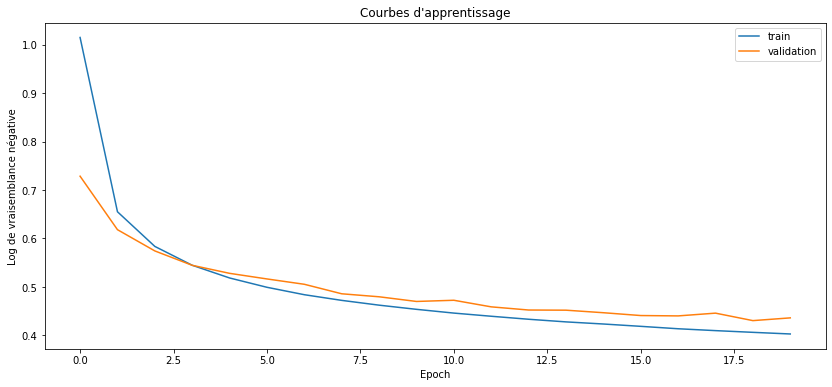

In [54]:
import time
from tensorflow import keras
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.datasets import fashion_mnist
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# import the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# shuffle the dataset
X_train, y_train = shuffle(X_train,y_train)

# pre-process: divide the "data" by 255 to shrink its size and keep it between [0-1]
X_train = X_train/255.0
X_test = X_test/255.0

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# split test data into test and validation
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# set up the DNN architecture
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(300, activation='relu', bias_initializer='ones' , use_bias=True))
model.add(Dense(300, activation='relu', bias_initializer='ones' , use_bias=True))
model.add(Dense(300, activation='relu', bias_initializer='ones' , use_bias=True))
model.add(Dense(10, activation='softmax', bias_initializer='ones' , use_bias=True))

# print the model summary
model.summary()

# set up parameters for the model
model.compile(optimizer=SGD(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# train the model, while collecting the loss calculated for each epoch
start_time = time.time()
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_validation, y_validation))
end_time = time.time()
# test the model and store the final loss and accuracy results
val_loss, val_acc = model.evaluate(X_validation, y_validation)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

training_time_keras = end_time - start_time
print("Training Time = %.3f seconds" % (training_time_keras))

# collect and plot the losses for the training and validation sets
losses_train = history.history['loss']
losses_val = history.history['val_loss']

plt.figure(figsize=(14, 6))
plt.plot(losses_train, label="train")
plt.plot(losses_val, label="validation")
plt.title('Courbes d\'apprentissage')
plt.ylabel('Log de vraisemblance négative')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.show()

## Comparison

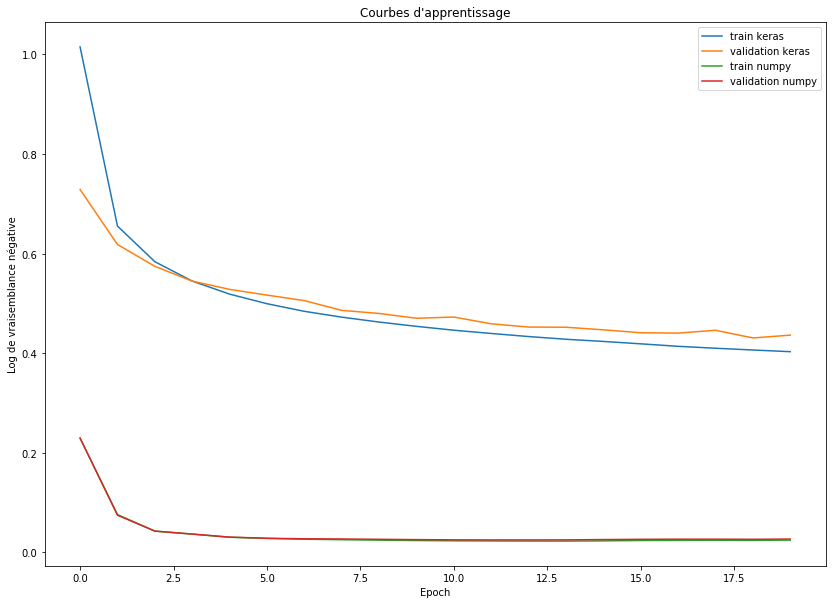

In [66]:
plt.figure(figsize=(14, 10))
plt.plot(losses_train, label="train keras")
plt.plot(losses_val, label="validation keras")
plt.plot(losses_train_numpy, label="train numpy")
plt.plot(losses_val_numpy, label="validation numpy")
plt.title('Courbes d\'apprentissage')
plt.ylabel('Log de vraisemblance négative')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

# Part II

Train on 60000 samples, validate on 5000 samples
Epoch 1/12
60000/60000 [==============================] - 4s 64us/step - loss: 0.8949 - acc: 0.6678 - val_loss: 0.5616 - val_acc: 0.7952
Epoch 2/12
60000/60000 [==============================] - 3s 57us/step - loss: 0.5892 - acc: 0.7833 - val_loss: 0.4489 - val_acc: 0.8342
Epoch 3/12
60000/60000 [==============================] - 3s 58us/step - loss: 0.5235 - acc: 0.8086 - val_loss: 0.4270 - val_acc: 0.8460
Epoch 4/12
60000/60000 [==============================] - 3s 56us/step - loss: 0.4887 - acc: 0.8219 - val_loss: 0.3876 - val_acc: 0.8592
Epoch 5/12
60000/60000 [==============================] - 3s 55us/step - loss: 0.4609 - acc: 0.8321 - val_loss: 0.3801 - val_acc: 0.8630
Epoch 6/12
60000/60000 [==============================] - 3s 56us/step - loss: 0.4439 - acc: 0.8382 - val_loss: 0.3643 - val_acc: 0.8670
Epoch 7/12
60000/60000 [==============================] - 3s 56us/step - loss: 0.4271 - acc: 0.8446 - val_loss: 0.3516 - val_acc:

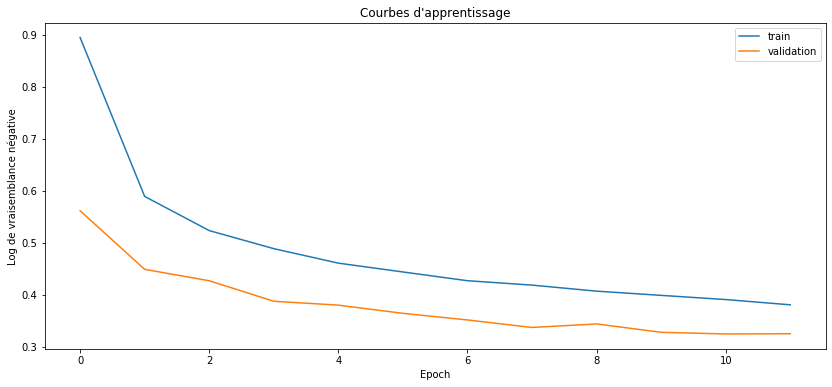

In [3]:
import time
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import backend as K

# import the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# shuffle the dataset
X_train, y_train = shuffle(X_train,y_train)

# reshape data to fit model
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

# pre-process: divide the "data" by 255 to shrink its size and keep it between [0-1]
X_train = X_train/255.0
X_test = X_test/255.0

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# split test data into test and validation
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


model_0 = Sequential()
model_0.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model_0.add(MaxPooling2D(pool_size=(4, 4)))
model_0.add(Conv2D(32, (3, 3), activation='relu'))
model_0.add(MaxPooling2D(pool_size=(2, 2)))
model_0.add(Dropout(0.5))
model_0.add(Flatten())
model_0.add(Dense(128, activation='relu'))
model_0.add(Dropout(0.25))
model_0.add(Dense(10, activation='softmax'))
model_0.compile(loss='categorical_crossentropy',optimizer=Adadelta(lr=1.0),metrics=['accuracy'])

models = [model_0]

for model in models:

    history = model.fit(X_train, y_train,
              batch_size=128,
              epochs=12,
              verbose=1,
              validation_data=(X_validation, y_validation))
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # collect and plot the losses for the training and validation sets
    losses_train = history.history['loss']
    losses_val = history.history['val_loss']

    plt.figure(figsize=(14, 6))
    plt.plot(losses_train, label="train")
    plt.plot(losses_val, label="validation")
    plt.title('Courbes d\'apprentissage')
    plt.ylabel('Log de vraisemblance négative')
    plt.xlabel('Epoch')
    plt.legend(loc='best')